### 1. Import and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2487,2596,1,0,109,2541.5,0,-109,0,20.0,...,1.0,0.0,4.0,2.0,6.0,36.0,36.0,0,15.0,0.0
1,2542,2433,2,0,109,2487.5,1,109,9,16.0,...,0.0,0.0,1.0,3.0,4.0,31.0,20.0,0,15.0,11.0
2,2404,2534,0,0,130,2469.0,0,-130,0,21.0,...,1.0,1.0,0.0,0.0,0.0,33.0,34.0,1,9.0,-1.0
3,2860,2922,1,0,62,2891.0,0,-62,0,33.0,...,1.0,0.0,0.0,0.0,0.0,39.0,39.0,0,4.0,0.0
4,2752,2395,2,0,357,2573.5,1,357,0,18.0,...,0.0,1.0,0.0,1.0,1.0,38.0,28.0,0,14.0,10.0


### 2. Prepare data

In [3]:
X = df.drop(['ResultNumeric'], axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (2435474, 33)
Target: (2435474,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [6]:
start_time = time.time()

xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 25.36 seconds (0.42 minutes)


### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.6245 (62.45%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.60      0.68      0.64    198257
        Draw       0.84      0.29      0.43     77234
   White Win       0.62      0.70      0.66    211604

    accuracy                           0.62    487095
   macro avg       0.69      0.56      0.58    487095
weighted avg       0.65      0.62      0.61    487095



### 6. Confusion Matrix

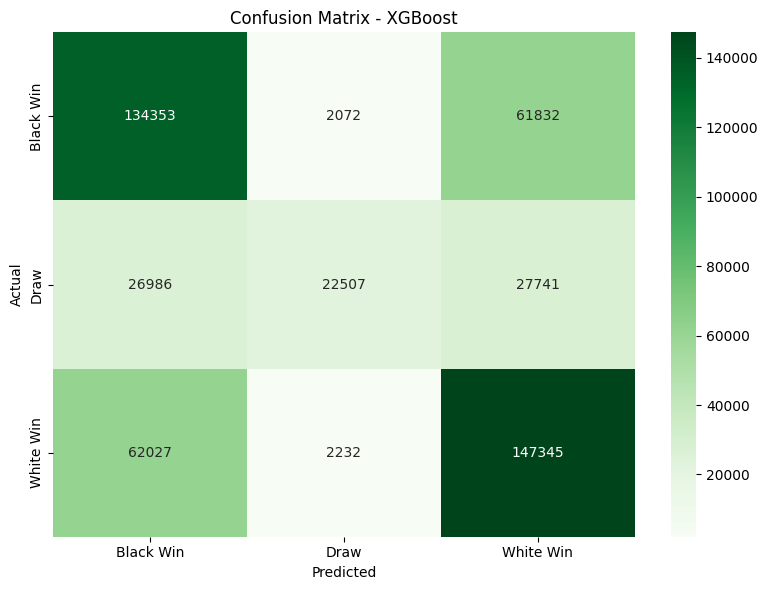

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                  Feature  Importance
4               AvgRating    0.266168
10    material_diff_early    0.121336
6    WhiteRatingAdvantage    0.113114
0                WhiteElo    0.064505
5      WhiteIsHigherRated    0.060839
1                BlackElo    0.050662
3              RatingDiff    0.042357
32          activity_diff    0.034241
9        b_material_early    0.027408
2             EventTypeID    0.027292
15     b_aggression_early    0.018031
29       b_piece_activity    0.017027
8        w_material_early    0.016642
16  aggression_diff_early    0.016590
28       w_piece_activity    0.015136
21          b_development    0.013466
13     capture_diff_early    0.011253
31   total_captures_early    0.011219
20          w_development    0.009255
26         b_checks_early    0.008580
22       development_diff    0.007877
12       b_captures_early    0.006969
11       w_captures_early    0.006042
14     w_aggression_early    0.005395
24        b_castled_early    0.005009
23        w_

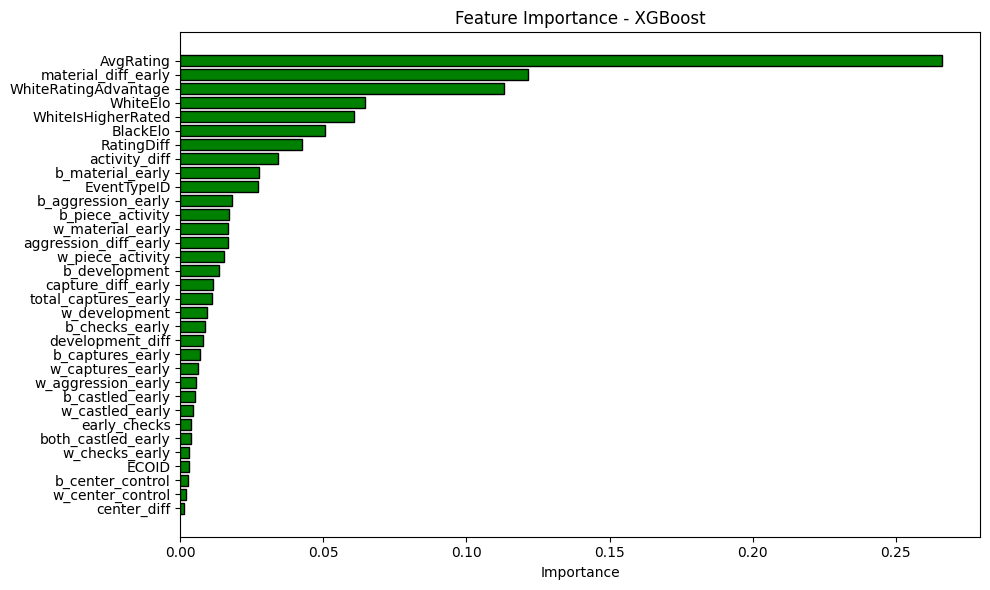

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()